In [1]:
# Download packages

from PIL import Image
import imageio
import multipagetiff as mtif

from matplotlib import pyplot as plt
#from skimage.color import rgb2gray
import scipy.ndimage as ndi 
import numpy as np

import skimage
from skimage.transform import rescale
from skimage.filters import threshold_otsu
from skimage.transform import resize
from skimage import io, morphology

plt.rcParams['figure.dpi'] = 1000
plt.rcParams['savefig.dpi'] = 1000

In [217]:
# Functions
def read_tiff(path):
    """
    path - Path to the multipage-tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(img.n_frames):
        img.seek(i)
        images.append(np.array(img))
    return np.array(images)



def cleaning_hole(image) : 
    thresh =  threshold_otsu(image)
    
    binary = np.where(image >=thresh, 1, 0)
    

    binary = ndi.binary_dilation(binary)
    binary = ndi.binary_closing(binary)
    binary = ndi.binary_erosion(binary)
    #binary = ndi.median_filter(binary, 10)
#    binary = skimage.morphology.closing(binary)
    binary = ndi.binary_fill_holes(binary)



    return binary

def sharpen_sig(image, alpha = 20) : 
    blurred_f = ndi.gaussian_filter(image, 3)
    filter_blurred_f = ndi.gaussian_filter(blurred_f, 1)
    
    sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)
    #sharpened = filter_blurred_f
    return sharpened

In [218]:
### Import component file

selected_tiff = read_tiff('Feria/[20456841_Scan1_Core[1,2,B]_[15665,38196]_component_data]_DAPI.tif')



In [219]:
selected_tiff.shape = (selected_tiff.shape[1],selected_tiff.shape[2],selected_tiff.shape[3])

In [220]:
selected_tiff.shape

(4396, 4396, 3)

In [221]:
dapi_img = selected_tiff[:,:,2]
dapi_img = sharpen_sig(dapi_img)
dapi_img = cleaning_hole(dapi_img)

2167693422.py (3): savefig() got unexpected keyword argument "cmap" which is no longer supported as of 3.3 and will become an error in 3.6


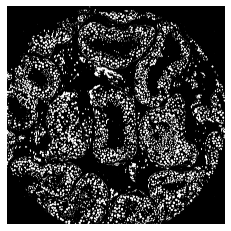

In [222]:
plt.imshow(dapi_img, cmap = 'gray')
plt.axis('off')
plt.savefig('Feria/Output/mask.tif', cmap = 'gray', dpi= 1000)

2782263914.py (3): savefig() got unexpected keyword argument "cmap" which is no longer supported as of 3.3 and will become an error in 3.6


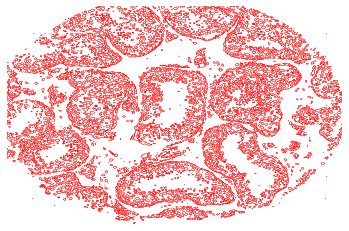

In [223]:
plt.contour(dapi_img, linewidths=.1, colors='r')
plt.axis('off')
plt.savefig('Feria/Output/contour.tif', cmap = 'gray', dpi= 1000)

In [224]:
mask = dapi_img.astype(int)

In [300]:
mask
np.savetxt('test1.txt', mask, fmt='%d')


In [225]:
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt
from stardist.models import StarDist2D

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

labels, _ = model.predict_instances(mask)

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2022-10-07 10:38:24.597972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


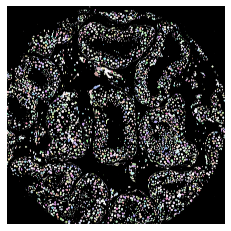

In [227]:
#plt.imshow(render_label(labels, img=selected_tiff[:, :, 2]))
plt.imshow(render_label(labels, img=mask))


plt.axis('off')
plt.savefig('Feria/Output/render_lab.tif', dpi= 1000)


In [293]:
values, counts = np.unique(labels, return_counts=True)


# Find the outliers of labels from Stardist

min_out = np.percentile(counts[1:], 50)
max_out = np.percentile(counts[1:], 100)
#iqr = q3-q1
#min_out = q1 -1.5*iqr
#max_out = q3 +1.5*iqr


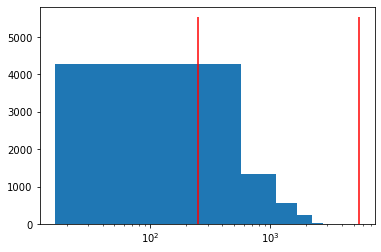

In [294]:
plt.hist(counts[1:])
plt.xscale('log')
plt.vlines(x = min_out, ymin = 0, ymax = max(counts[1:]), colors = 'red')
plt.vlines(x = max_out, ymin = 0, ymax = max(counts[1:]), colors = 'red')

In [295]:
selected_cell = (counts <= max_out) & (counts >= min_out)
selected_values = values[selected_cell]
non_selected_values = values[selected_cell == False]

non_selected_values

array([   0,  550,  779, ..., 6483, 6484, 6485], dtype=int32)

In [296]:
cleaned_labels = np.copy(labels)
for i in non_selected_values: 
    cleaned_labels = np.where(cleaned_labels == i, 0,cleaned_labels)

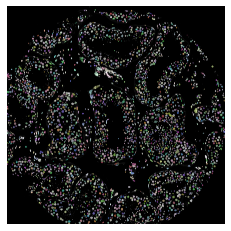

In [297]:
plt.imshow(render_label(cleaned_labels, img=selected_tiff[:, :, 2]))
#plt.imshow(render_label(cleaned_labels, img=mask))


plt.axis('off')
plt.savefig('Feria/Output/cleaned_render_lab.tif', dpi= 1000)



In [292]:
dataset = dapi_img
len_val =np.amax(labels)
ext_mx = []

for im in dataset :
    data_mx = normalize(im)
    sum_mx = np.zeros((len_val,), dtype = float)
    
    for label in range(1, len_val ):
                check_mx = np.where(labels == label, 1, 0)
                expression = check_mx * data_mx
                sum_mx[label] = np.sum(expression)
    ext_mx.append(sum_mx)

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [28]:
import pandas as pd

df = pd.DataFrame(np.array(ext_mx).T, columns = ['im_480', 'im_520', 'im_570', 'im_650', 'im_690', 'im_780', 'DAPI', 'AF'])

In [301]:
df[1:,]

NameError: name 'df' is not defined

In [63]:
df_drop = df.iloc[1:, :5]
#df_drop = df_drop.loc[(df_drop != 0).any(axis=1)]
df_drop = df_drop.div(df_drop.sum(axis=1), axis=0)
df_drop = np.around(df_drop, 0)
#df_drop = df_drop.dropna()
#df_drop = df_drop.loc[(df_drop != 0).any(axis=1)]

#df_drop = df_drop.nan_to_num(0)
#df_drop.to_csv('leoout.csv') 
df_drop

,im_480,im_520,im_570,im_650,im_690
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
1283,0.0,1.0,0.0,0.0,0.0
1284,0.0,0.0,0.0,0.0,1.0
1285,0.0,0.0,0.0,1.0,0.0
1286,0.0,0.0,0.0,1.0,0.0


In [65]:
df_drop = df.iloc[1:, :5]
#df_drop = df_drop.loc[(df_drop != 0).any(axis=1)]
df_drop = df_drop.div(df_drop.sum(axis=1), axis=0)
#df_drop = np.around(df_drop, 0)
#df_drop = df_drop.dropna()
#df_drop = df_drop.loc[(df_drop != 0).any(axis=1)]

#df_drop = df_drop.nan_to_num(0)
df_drop.to_csv('leoout.csv') 
df_drop

,im_480,im_520,im_570,im_650,im_690
1,0.018713,0.440546,0.0,0.000000,0.540741
2,0.333051,0.666949,0.0,0.000000,0.000000
3,0.168441,0.000000,0.0,0.831559,0.000000
4,0.593621,0.000000,0.0,0.406379,0.000000
5,0.028766,0.376046,0.0,0.000000,0.595188
...,...,...,...,...,...
1283,0.000000,1.000000,0.0,0.000000,0.000000
1284,0.000000,0.000000,0.0,0.000000,1.000000
1285,0.000000,0.000000,0.0,1.000000,0.000000
1286,0.000000,0.000000,0.0,1.000000,0.000000


In [ ]:
height,width = labels.shape
labels 

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_drop)

#print(pca.explained_variance_ratio_)

principalComponents = pca.fit_transform(df_drop)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
principalDf.plot.scatter(x='PC1', y='PC2', alpha = .5)


In [ ]:
principalDf.plot.scatter(x='PC2', y='PC3', alpha = .5)

In [45]:
principalComponents.shape

(1159, 5)

In [46]:
correlation_matrix = df_drop.corr()

In [47]:
df_drop.values

array([[0.00000000e+00, 0.00000000e+00, 3.76612516e-05, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.32966969e-05, 0.00000000e+00,
        0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])